# Moving Averge-based Trading Strategies

## Fetching Data from CryptoCompare

In [1]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plot

from datetime import datetime
import time

# ----- User Settings 
coins=['BTC', 'ETH','LTC','MKR','AAVE', 'BAL', 'UNI', 'LDO', 'MATIC','LINK']
#coins=['BTC', 'ETH','LTC','LINK']

trading_fee = 0.5/100 
collectDataFrom = pd.Timestamp('2010-01-01')
trading_range = [+0.02,+2]
#buyAbove='sma7d'
#buyAbove='sma50d'
#buyAbove='sma200d'
buyAbove='sma200w'

cryptocompare_api_key='777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'


# ----- User Settings -- end

coin_colors = {
    'BTC':'orange',
    'ETH':'grey',
    'AAVE':'purple',
    'LTC':'lightblue',
    'MKR':'lightgreen',
    'MATIC':'blue',
    'UNI':'pink',
    'LDO':'darkred',
    'BAL':'brown',
    'LQTY':'teal',
    'BIFI' :'lightgrey',
    'LINK' : 'darkblue'
}

initial_coin = 1
initial_usd = 0
limit=2000

coin_dfs=[]
for coin in coins:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while collectDataFrom <= timestamp : 
        requestString = 'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&limit={}&api_key={}&toTs={}'\
        .format(coin, limit, cryptocompare_api_key, timestamp.timestamp())
        # print("Request : " + requestString)    
        response = requests.get(requestString).text 
        parsed = json.loads(response)
        segment_df = pd.DataFrame(parsed['Data']['Data'])
        segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
        segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
        segment_df.sort_index()

        #segment_df.drop_duplicates(inplace=True)
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day        
        #segment_df= segment_df.head(1)
        time_segments.append(segment_df)
          
    df = pd.concat(time_segments, axis=0)
    df = pd.concat({coin: df}, axis=1, names=["Coin", "Metrics"])
    df.drop_duplicates(inplace=True)
    df.drop(columns=['volumefrom','volumeto','conversionType','conversionSymbol'], level='Metrics', inplace=True)
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[collectDataFrom:]
df.sort_index(inplace=True)
df


Coin                BTC                                             ETH  \
Metrics            high          low         open        close     high   
time                                                                      
2010-07-17      0.04951      0.04951      0.04951      0.04951      NaN   
2010-07-18      0.08585      0.05941      0.04951      0.08584      NaN   
2010-07-19      0.09307      0.07723      0.08584      0.08080      NaN   
2010-07-20      0.08181      0.07426      0.08080      0.07474      NaN   
2010-07-21      0.07921      0.06634      0.07474      0.07921      NaN   
...                 ...          ...          ...          ...      ...   
2022-12-19  16813.47000  16350.32000  16742.74000  16442.79000  1194.49   
2022-12-20  17028.68000  16404.94000  16442.79000  16901.12000  1228.37   
2022-12-21  16922.92000  16737.80000  16901.12000  16821.13000  1220.46   
2022-12-22  16860.78000  16571.31000  16821.13000  16816.01000  1230.41   
2022-12-23  16907.78000  16763.01000  16816.01000  16836.72000  1228.48   

Coin                                     LTC         ...     LDO          \
Metrics         low     open    close   high    low  ...    open   close   
time                                                 ...                   
2010-07-17      NaN      NaN      NaN    NaN    NaN  ...     NaN     NaN   
2010-07-18      NaN      NaN      NaN    NaN    NaN  ...     NaN     NaN   
2010-07-19      NaN      NaN      NaN    NaN    NaN  ...     NaN     NaN   
2010-07-20      NaN      NaN      NaN    NaN    NaN  ...     NaN     NaN   
2010-07-21      NaN      NaN      NaN    NaN    NaN  ...     NaN     NaN   
...             ...      ...      ...    ...    ...  ...     ...     ...   
2022-12-19  1152.43  1183.19  1167.68  65.03  61.04  ...  0.9811  0.9500   
2022-12-20  1163.29  1167.68  1216.96  66.60  63.12  ...  0.9500  0.9900   
2022-12-21  1204.40  1216.96  1213.84  66.80  64.63  ...  0.9900  0.9390   
2022-12-22  1183.80  1213.84  1217.51  66.66  64.28  ...  0.9390  0.8959   
2022-12-23  1213.65  1217.51  1218.30  66.68  65.05  ...  0.9013  0.9217   

Coin         MATIC                           LINK                       
Metrics       high     low    open   close   high    low   open  close  
time                                                                    
2010-07-17     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN  
2010-07-18     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN  
2010-07-19     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN  
2010-07-20     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN  
2010-07-21     NaN     NaN     NaN     NaN    NaN    NaN    NaN    NaN  
...            ...     ...     ...     ...    ...    ...    ...    ...  
2022-12-19  0.8217  0.7583  0.8124  0.7736  6.067  5.680  5.950  5.788  
2022-12-20  0.8088  0.7682  0.7736  0.8016  6.119  5.754  5.788  6.017  
2022-12-21  0.8034  0.7856  0.8016  0.7942  6.040  5.886  6.017  5.990  
2022-12-22  0.7975  0.7699  0.7942  0.7961  6.039  5.854  5.990  6.003  
2022-12-23  0.8072  0.7915  0.7961  0.7994  6.052  5.963  6.003  5.982  

[4538 rows x 40 columns]

## Narrowing Input and Refining Input Parameters

In [2]:
# ----- User Settings Overrides
#coins=['BTC', 'ETH','LTC','MKR','AAVE', 'BAL', 'UNI', 'LDO', 'MATIC','LINK']
coins=['ETH','BTC','LTC']

trading_fee = 0.5/100 
trading_range = [+0.02,+2]
#buyAbove='sma7d'
#buyAbove='sma50d'
#buyAbove='sma200d'
buyAbove='sma200w'
# df=df.loc['2020-01-01':]

## Adding Extra Columns

In [3]:
for coin in coins:
    
    # Adding Simple Moving Average Columns
    df.loc(axis=1)[(coin,'sma7d')] = df.loc(axis=1)[(coin,'close')].rolling(7).mean()
    df.loc(axis=1)[(coin,'sma50d')] = df.loc(axis=1)[(coin,'close')].rolling(50).mean()
    df.loc(axis=1)[(coin,'sma200d')] = df.loc(axis=1)[(coin,'close')].rolling(200).mean()
    df.loc(axis=1)[(coin,'sma200w')] = df.loc(axis=1)[(coin,'close')].rolling(200*7).mean()
    # Adding ExponentialMoving Average Columns
    #df.loc(axis=1)[(coin,'ema21w')] = df.loc(axis=1)[(coin,'close')].ewm(span=21*7, adjust=False).mean()
    
    # Setting Initial coins

    df.loc(axis=1)[(coin,'usd_bag')] = initial_usd;
    df.loc(axis=1)[(coin,'coin_bag')] = initial_coin;
df.sort_index(axis=1,inplace=True, level='Coin',sort_remaining=False)
df['ETH']




Metrics,high,low,open,close,sma7d,sma50d,sma200d,sma200w,usd_bag,coin_bag
time,,,,,,,,,,
2010-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2010-07-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2010-07-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2010-07-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
2010-07-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1
...,...,...,...,...,...,...,...,...,...,...
2022-12-19,1194.49,1152.43,1183.19,1167.68,1228.621429,1285.7850,1411.04610,1355.389429,0,1
2022-12-20,1228.37,1163.29,1167.68,1216.96,1213.840000,1278.6666,1408.26295,1356.155786,0,1
2022-12-21,1220.46,1204.40,1216.96,1213.84,1200.460000,1271.3732,1405.31390,1356.916479,0,1


## Calculate Trading Strategy Results

In [4]:


def trade_by_above_ma(row, ma_column='sma7d'):

    isAboveSMA = row['close'] > row[ma_column]
    coin_bag = row['coin_bag']
    usd_bag = row['usd_bag']
    if pd.isna(row['close']):
        return coin_bag, usd_bag 
    if isAboveSMA == True:  # Buy
        if usd_bag>0:
            coin_bag =  row['coin_bag'] + (1-trading_fee) * row['usd_bag']/row['close']  
            usd_bag = 0
    else:                   # Sell
        if coin_bag>0: 
            usd_bag = row['usd_bag'] + (1-trading_fee) * row['coin_bag']*row['close']
            coin_bag = 0
    return coin_bag, usd_bag 


def trade_by_ma_range(row, ma_column='sma7d', trading_range = [-0.1,+0.1] ):
    
    coin_bag = row['coin_bag']
    usd_bag = row['usd_bag']
    if pd.isna(row['close']):
        return coin_bag, usd_bag 
    if row['close'] < (1+trading_range[0])*row[ma_column] :    
        if usd_bag>0:  # Buy
            coin_bag =  row['coin_bag'] + (1-trading_fee) * row['usd_bag']/row['close']  
            usd_bag = 0
    else :
        if row['close'] > (1+trading_range[1])*row[ma_column] :
            if coin_bag>0: # Sell
                usd_bag = row['usd_bag'] + (1-trading_fee) * row['coin_bag']*row['close']
                coin_bag = 0
    return coin_bag, usd_bag 



for coin in coins:
    
    usd_bag=initial_usd
    coin_bag=initial_coin

    for index, row in df[coin].iterrows():

        row['coin_bag'] = coin_bag
        row['usd_bag'] = usd_bag
        #coin_bag, usd_bag = trade_by_above_ma(row, ma_column=buyAbove)
        coin_bag, usd_bag = trade_by_ma_range(row, ma_column=buyAbove, trading_range=trading_range )
        #df[coin].loc[index,'coin_bag'] = coin_bag
        df.loc[index,(coin,'coin_bag')] = coin_bag
        df.loc[index,(coin,'usd_bag')] = usd_bag
        #df[coin].loc[index,'usd_bag'] = usd_bag
    # df[coin]['usd_value'] = df[coin]['usd_bag'] + df[coin]['coin_bag']*df[coin]['close']
    df.loc(axis=1)[(coin,'trade_usd_value')] = df[coin]['usd_bag'] + df[coin]['coin_bag']*df[coin]['close']
    df.loc(axis=1)[(coin,'hodl_usd_value')] = df[coin]['close']*initial_coin + initial_usd
    df.loc(axis=1)[(coin,'trade_success_rate')] = df[coin]['trade_usd_value'] / df[coin]['hodl_usd_value'] 

df.sort_index(axis=1,inplace=True, level='Coin',sort_remaining=False)
df

Coin         AAVE                         BAL                       \
Metrics      high    low   open  close   high    low   open  close   
time                                                                 
2010-07-17    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-07-18    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-07-19    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-07-20    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
2010-07-21    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
...           ...    ...    ...    ...    ...    ...    ...    ...   
2022-12-19  56.53  53.05  55.77  53.79  5.560  5.172  5.491  5.260   
2022-12-20  56.28  53.20  53.79  55.64  5.620  5.230  5.260  5.510   
2022-12-21  56.44  54.63  55.64  56.01  5.640  5.410  5.510  5.570   
2022-12-22  56.08  53.66  56.01  55.63  5.602  5.360  5.570  5.542   
2022-12-23  56.11  54.39  55.63  54.65  5.619  5.530  5.542  5.569   

Coin                BTC               ...   MATIC             MKR          \
Metrics            high          low  ...    open   close    high     low   
time                                  ...                                   
2010-07-17      0.04951      0.04951  ...     NaN     NaN     NaN     NaN   
2010-07-18      0.08585      0.05941  ...     NaN     NaN     NaN     NaN   
2010-07-19      0.09307      0.07723  ...     NaN     NaN     NaN     NaN   
2010-07-20      0.08181      0.07426  ...     NaN     NaN     NaN     NaN   
2010-07-21      0.07921      0.06634  ...     NaN     NaN     NaN     NaN   
...                 ...          ...  ...     ...     ...     ...     ...   
2022-12-19  16813.47000  16350.32000  ...  0.8124  0.7736  558.61  522.39   
2022-12-20  17028.68000  16404.94000  ...  0.7736  0.8016  559.60  526.72   
2022-12-21  16922.92000  16737.80000  ...  0.8016  0.7942  558.30  544.33   
2022-12-22  16860.78000  16571.31000  ...  0.7942  0.7961  555.45  537.39   
2022-12-23  16907.78000  16763.01000  ...  0.7961  0.7994  557.02  549.31   

Coin                          UNI                       
Metrics       open   close   high    low   open  close  
time                                                    
2010-07-17     NaN     NaN    NaN    NaN    NaN    NaN  
2010-07-18     NaN     NaN    NaN    NaN    NaN    NaN  
2010-07-19     NaN     NaN    NaN    NaN    NaN    NaN  
2010-07-20     NaN     NaN    NaN    NaN    NaN    NaN  
2010-07-21     NaN     NaN    NaN    NaN    NaN    NaN  
...            ...     ...    ...    ...    ...    ...  
2022-12-19  553.44  527.56  5.426  5.005  5.327  5.092  
2022-12-20  527.56  557.03  5.394  5.050  5.092  5.361  
2022-12-21  557.03  552.17  5.366  5.201  5.361  5.315  
2022-12-22  552.17  551.61  5.415  5.174  5.311  5.381  
2022-12-23  551.61  552.65  5.400  5.235  5.362  5.238  

[4538 rows x 67 columns]

## Showing Results

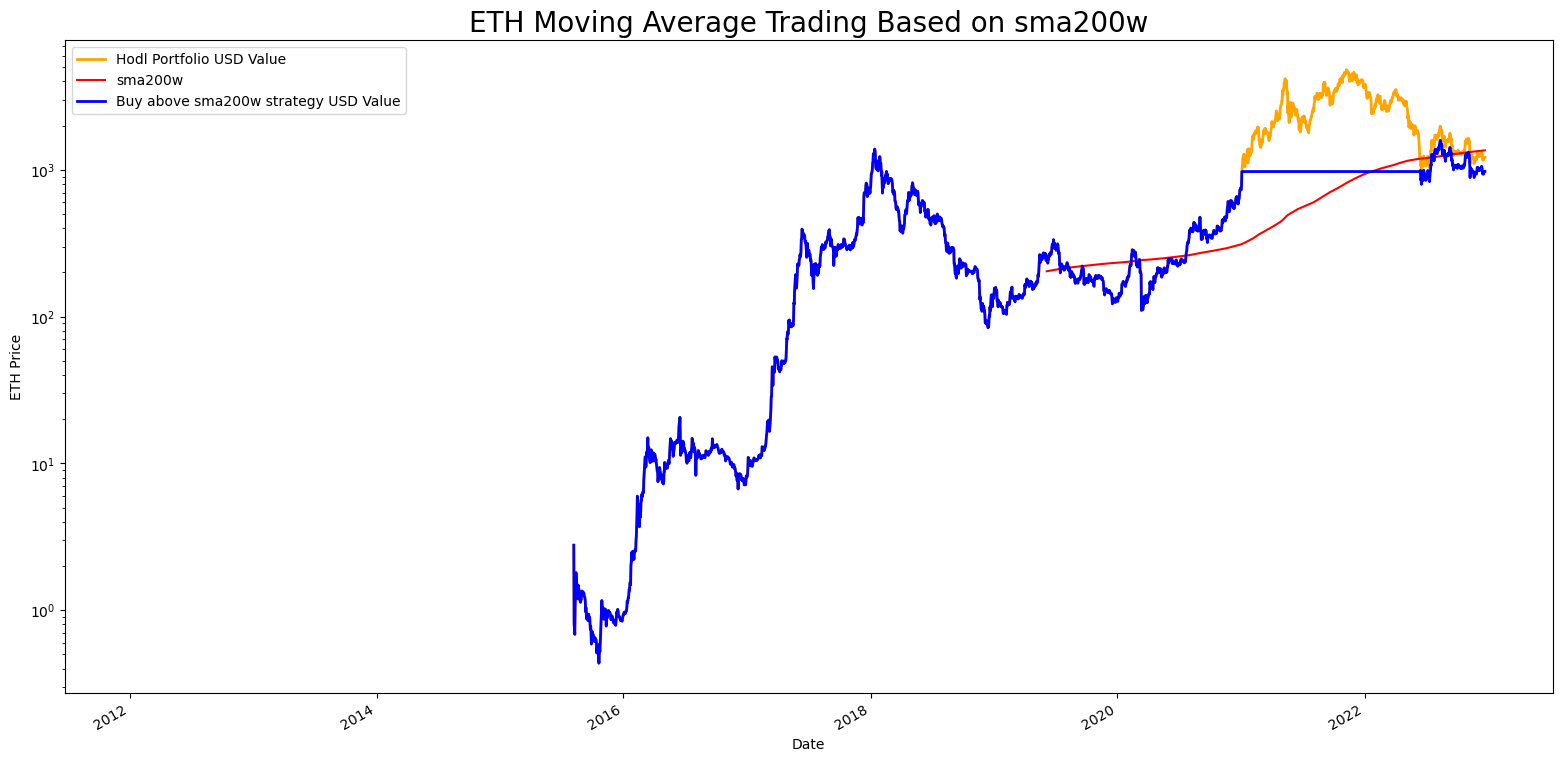

In [5]:
coin='ETH'
df[coin]['close'].plot(c='orange',label='Hodl Portfolio USD Value',linewidth=2)
df[coin][buyAbove].plot(c='red',label=buyAbove)
df[coin]['trade_usd_value'].plot(c='blue',label='Buy above {} strategy USD Value'.format(buyAbove),linewidth=2)


plot.title("{} Moving Average Trading Based on {}".format(coin, buyAbove), fontsize=20)
plot.ylabel("{} Price".format(coin))
plot.xlabel('Date')
plot.legend()
plot.yscale('log')
F = plot.gcf()

# Now check everything with the defaults:
#DPI = F.get_dpi()
#print ("DPI:", DPI)
DefaultSize = F.get_size_inches()
#print ("Default size in Inches", DefaultSize)
#print ("Which should result in a %i x %i Image"%(DPI*DefaultSize[0], DPI*DefaultSize[1]))
# the default is 100dpi for savefig:
#F.savefig("test1.png")
# this gives me a 797 x 566 pixel image, which is about 100 DPI

# Now make the image twice as big, while keeping the fonts and all the
# same size
F.set_size_inches( (DefaultSize[0]*3, DefaultSize[1]*2) )

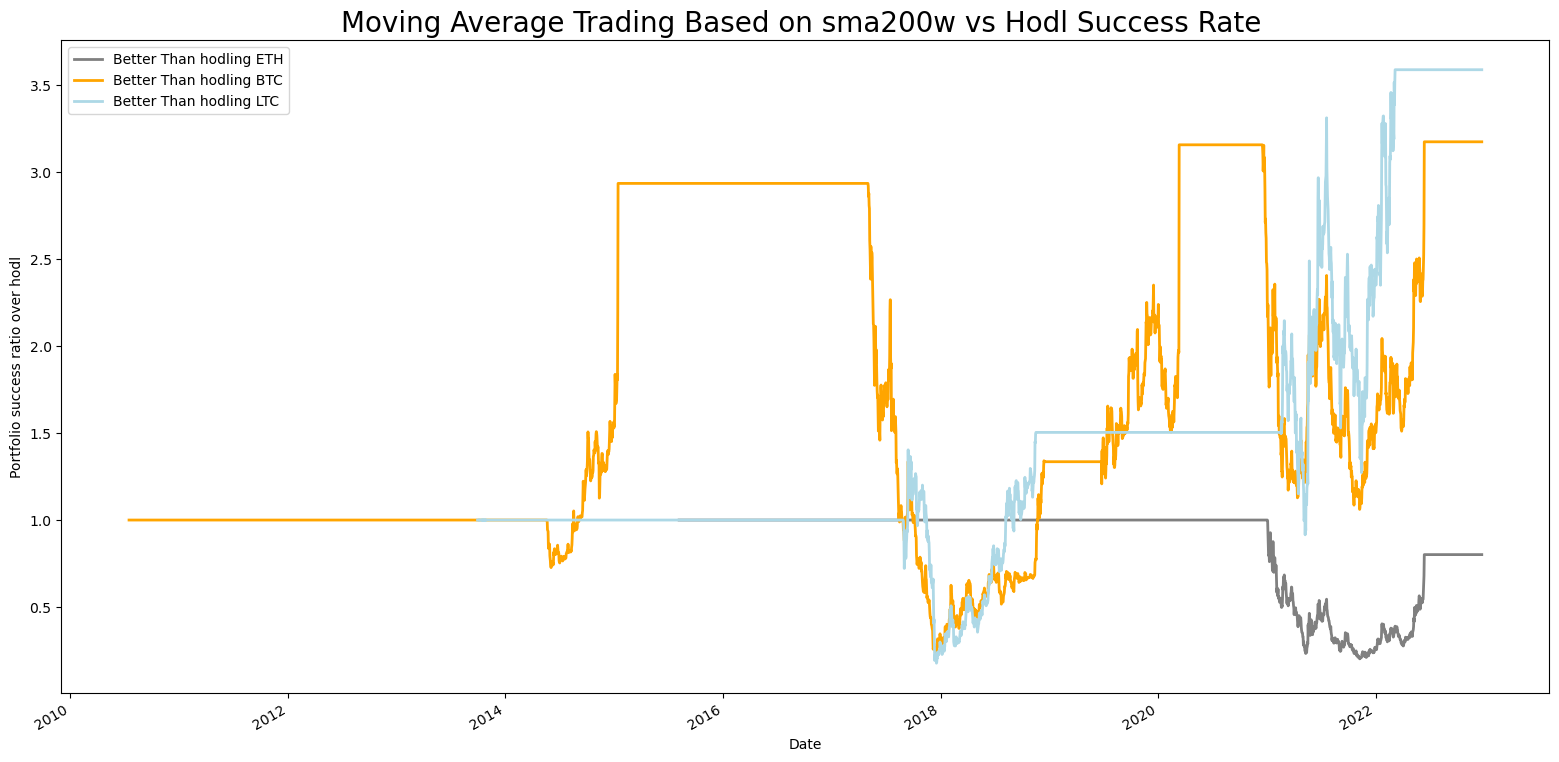

In [6]:

for coin in coins:
    df[coin]['trade_success_rate'].plot(c=coin_colors[coin],label="Better Than hodling {}".format(coin),linewidth=2)

plot.title("Moving Average Trading Based on {} vs Hodl Success Rate ".format(buyAbove), fontsize=20)
plot.ylabel("Portfolio success ratio over hodl")
plot.xlabel('Date')
plot.legend()
F = plot.gcf()
DefaultSize = F.get_size_inches()

F.set_size_inches( (DefaultSize[0]*3, DefaultSize[1]*2) )

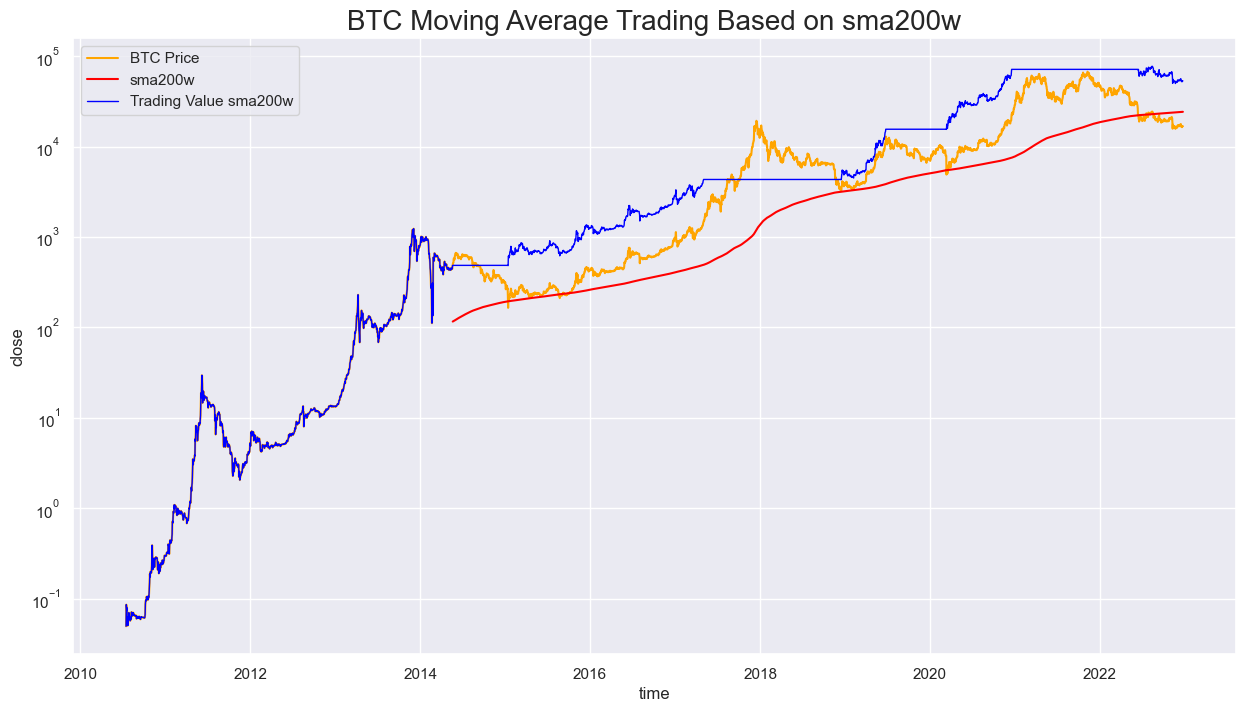

In [24]:
# Apply the default theme
import seaborn as sns
coin='BTC'
sns.set_theme( palette="pastel")
sns.set(rc = {'figure.figsize':(15,8)})

plot.title("{} Moving Average Trading Based on {}".format(coin, buyAbove), fontsize=20)
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['close'], color=coin_colors[coin],label='{} Price'.format(coin))
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin][buyAbove], color='red', label=buyAbove)
g_results=sns.lineplot(data=df[coin], x=df[coin].index, y=df[coin]['trade_usd_value'], color='blue', label='Trading Value {}'.format(buyAbove),linewidth=1)

g_results.set(yscale='log')
plot.legend()